In [1]:
import random
import numpy as np
import numpy.matlib
import pandas as pd

csv_data = pd.read_csv('trade_new.csv')  # 读取数据
csv_data['type5'] = csv_data.apply(lambda x: str(x['pluno'])[:5], axis=1)
memberSum = csv_data.groupby([csv_data['vipno'], csv_data['type5']])['amt'].sum()
customer = memberSum.index.levels[0]
size = len(customer)
dict_customer = {}
for i in range(size):
    dict_customer[customer[i]] = i

In [15]:
def jaccard(userId1, userId2):
    if userId1 == userId2:
        return 1.0
    return jaccardSeri(memberSum.loc[userId1], memberSum.loc[userId2])

def jaccardSeri(user1, user2):
    sim = 0
    user1 = pd.DataFrame(user1)
    user2 = pd.DataFrame(user2)
    for i, row in user1.iterrows():
        user1.loc[i,"type5"] = i
    user1["type4"] = user1.apply(lambda x:str(x["type5"])[:4], axis = 1)
    user1["type3"] = user1.apply(lambda x:str(x["type5"])[:3], axis = 1)
    user1["type2"] = user1.apply(lambda x:str(x["type5"])[:2], axis = 1)
    for i, row in user2.iterrows():
        user2.loc[i,"type5"] = i
    user2["type4"] = user2.apply(lambda x:str(x["type5"])[:4], axis = 1)
    user2["type3"] = user2.apply(lambda x:str(x["type5"])[:3], axis = 1)
    user2["type2"] = user2.apply(lambda x:str(x["type5"])[:2], axis = 1)
#     print(user1, user2)
    for i in range(2, 6):
        sum_user1 = user1.groupby(user1['type'+str(i)])['amt'].sum()
        sum_user2 = user2.groupby(user2['type'+str(i)])['amt'].sum()                      
        jiao = 0
        bing = 0
        for j in sum_user2.index:
            if j in sum_user1.index:
                jiao = jiao + min(sum_user1.loc[j], sum_user2.loc[j])
                bing = bing + max(sum_user1.loc[j], sum_user2.loc[j])
            else:
                bing = bing + sum_user2.loc[j]
        for j in sum_user1.index:
            if j not in sum_user2.index:
                bing = bing + sum_user1.loc[j]
        sim = sim + jiao / bing * (i+1)
    return sim/4

In [16]:
matrix = np.matlib.ones((size, size))
for i in range(size):
    for j in range(i+1, size):
        matrix[i,j] = jaccard(customer[i], customer[j])
        matrix[j,i] = matrix[i,j]

In [18]:
pointNum_list = [1]
sc_list = []
cp_list = []

for times in range(8):
    pointNum = pointNum_list[-1]
    pointNum_list.append(2*pointNum)
    # 初始化质心，设置种子方便复现
    random.seed(2020)
    beginCentroids = [int(size * random.random())]
    while len(beginCentroids) < pointNum:
        minIndex = 0
        minValue = 1
        for i in range(size):
            if i in beginCentroids:
                continue
            maxV = 0
            for j in beginCentroids:
#                 distance = jaccard(customer[i], customer[j])
                distance =  matrix[i, j]
                if distance > maxV:
                    maxV = distance
            if maxV < minValue:
                minValue = maxV
                minIndex = i
        beginCentroids.append(minIndex)
    # 开始聚类
    clusters = []
    nowCentroids = []
    for i in beginCentroids:
        clusters.append([customer[i]])
        nowCentroids.append(memberSum.loc[customer[i]])
    # 其他点聚类
    for i in range(size):
        if i in beginCentroids:
            continue
        clusterIndex = 0
        clusterValue = 0
        for j in range(pointNum):
            distance = jaccardSeri(memberSum.loc[customer[i]], nowCentroids[j])
            if clusterValue < distance:
                clusterValue = distance
                clusterIndex = j
        nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:x*len(clusters[clusterIndex]))
        clusters[clusterIndex].append(customer[i])
        for j in memberSum.loc[customer[i]].index:
            if j in nowCentroids[clusterIndex].index:
                nowCentroids[clusterIndex].loc[j] = nowCentroids[clusterIndex].loc[j] + memberSum.loc[customer[i]].loc[j]
            else:
                nowCentroids[clusterIndex].loc[j] = memberSum.loc[customer[i]].loc[j]
        nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:x/len(clusters[clusterIndex]))
    # 起始点聚类
    for i in range(pointNum):
        clusterIndex = 0
        clusterValue = 0
        for j in range(pointNum):
            distance = jaccardSeri(memberSum.loc[customer[beginCentroids[i]]], nowCentroids[j])
            if clusterValue < distance:
                clusterValue = distance
                clusterIndex = j
        if clusterIndex != i:
            nowCentroids[i] = nowCentroids[i].apply(lambda x:x*len(clusters[i]))
            nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:x*len(clusters[clusterIndex]))
            delete = clusters[i].pop(0)
            clusters[clusterIndex].append(delete)
            for k in memberSum.loc[delete].index:
                if k in nowCentroids[i].index:
                    nowCentroids[i].loc[k] = nowCentroids[i].loc[k] - memberSum.loc[delete].loc[k]
                if k in nowCentroids[clusterIndex].index:
                    nowCentroids[clusterIndex].loc[k] = nowCentroids[clusterIndex].loc[k] + memberSum.loc[delete].loc[k]
                else:
                    nowCentroids[clusterIndex].loc[k] = memberSum.loc[delete].loc[k]
            nowCentroids[i] = nowCentroids[i].apply(lambda x:0 if len(clusters[i])==0 else x/len(clusters[i]))
            nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:0 if len(clusters[clusterIndex])==0 else x/len(clusters[clusterIndex]))
    # 计算sc
    sc = 0
    for i in range(pointNum):
        if len(clusters[i]) == 0:
            continue
        for customerId in clusters[i]:
            a = 0
            b = 0
            for j in range(pointNum):
                if i == j:
                    for otherC in clusters[j]:
                        a = a + 1 - matrix[dict_customer[customerId], dict_customer[otherC]]
#                             a = a + 1 - jaccard(customerId, otherC)
                else:
                    for otherC in clusters[j]:
                        b = b + 1 - matrix[dict_customer[customerId], dict_customer[otherC]]
#                         tem = 1 - jaccard(customerId, otherC)
            if len(clusters[i]) == 1:
                a = 0
            else:
                a = a/(len(clusters[i])-1)
            if len(clusters[i]) == size:
                b = 0
            else:
                b = b/(size - len(clusters[i]))
            sc = sc + (b-a)/max(a, b)
    sc_list.append(sc/size)
    # 计算cp
    cp = 0
    for i in range(pointNum):
        if len(clusters[i]) == 0:
            continue
        cpi = 0
        for j in clusters[i]:
            cpi = cpi + 1 - jaccardSeri(memberSum.loc[j], nowCentroids[i])
        cp = cp + cpi/len(clusters[i])
    cp_list.append(cp/pointNum)

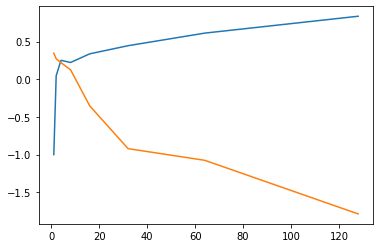

In [19]:
import matplotlib.pyplot as plt

pointNum_list.pop(-1)
plt.plot(pointNum_list, sc_list)
plt.plot(pointNum_list, cp_list)
plt.show()

In [20]:
print(pointNum_list)
print(sc_list)
print(cp_list)

[1, 2, 4, 8, 16, 32, 64, 128]
[-1.0, 0.04816548824010907, 0.2522105920053238, 0.22334526408249222, 0.3384616420653611, 0.44633119415139144, 0.6133872357080888, 0.8373833312362445]
[0.34703238513733636, 0.2725313432118409, 0.22058929234249047, 0.1267658158052421, -0.353146016250106, -0.9204470633268756, -1.0753647799577781, -1.7869698941663692]


In [25]:
pointNum_list_2 = [13, 14, 15, 16, 17, 18]
sc_list_2 = []
cp_list_2 = []
clusterList = {}

for pointNum in pointNum_list_2:
    # 初始化质心，设置种子方便复现
    random.seed(2020)
    beginCentroids = [int(size * random.random())]
    while len(beginCentroids) < pointNum:
        minIndex = 0
        minValue = 1
        for i in range(size):
            if i in beginCentroids:
                continue
            maxV = 0
            for j in beginCentroids:
#                 distance = jaccard(customer[i], customer[j])
                distance =  matrix[i, j]
                if distance > maxV:
                    maxV = distance
            if maxV < minValue:
                minValue = maxV
                minIndex = i
        beginCentroids.append(minIndex)
    # 开始聚类
    clusters = []
    nowCentroids = []
    for i in beginCentroids:
        clusters.append([customer[i]])
        nowCentroids.append(memberSum.loc[customer[i]])
    # 其他点聚类
    for i in range(size):
        if i in beginCentroids:
            continue
        clusterIndex = 0
        clusterValue = 0
        for j in range(pointNum):
            distance = jaccardSeri(memberSum.loc[customer[i]], nowCentroids[j])
            if clusterValue < distance:
                clusterValue = distance
                clusterIndex = j
        nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:x*len(clusters[clusterIndex]))
        clusters[clusterIndex].append(customer[i])
        for j in memberSum.loc[customer[i]].index:
            if j in nowCentroids[clusterIndex].index:
                nowCentroids[clusterIndex].loc[j] = nowCentroids[clusterIndex].loc[j] + memberSum.loc[customer[i]].loc[j]
            else:
                nowCentroids[clusterIndex].loc[j] = memberSum.loc[customer[i]].loc[j]
        nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:x/len(clusters[clusterIndex]))
    # 起始点聚类
    for i in range(pointNum):
        clusterIndex = 0
        clusterValue = 0
        for j in range(pointNum):
            distance = jaccardSeri(memberSum.loc[customer[beginCentroids[i]]], nowCentroids[j])
            if clusterValue < distance:
                clusterValue = distance
                clusterIndex = j
        if clusterIndex != i:
            nowCentroids[i] = nowCentroids[i].apply(lambda x:x*len(clusters[i]))
            nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:x*len(clusters[clusterIndex]))
            delete = clusters[i].pop(0)
            clusters[clusterIndex].append(delete)
            for k in memberSum.loc[delete].index:
                if k in nowCentroids[i].index:
                    nowCentroids[i].loc[k] = nowCentroids[i].loc[k] - memberSum.loc[delete].loc[k]
                if k in nowCentroids[clusterIndex].index:
                    nowCentroids[clusterIndex].loc[k] = nowCentroids[clusterIndex].loc[k] + memberSum.loc[delete].loc[k]
                else:
                    nowCentroids[clusterIndex].loc[k] = memberSum.loc[delete].loc[k]
            nowCentroids[i] = nowCentroids[i].apply(lambda x:0 if len(clusters[i])==0 else x/len(clusters[i]))
            nowCentroids[clusterIndex] = nowCentroids[clusterIndex].apply(lambda x:0 if len(clusters[clusterIndex])==0 else x/len(clusters[clusterIndex]))
    clusterList[pointNum] = clusters
    # 计算sc
    sc = 0
    for i in range(pointNum):
        if len(clusters[i]) == 0:
            continue
        for customerId in clusters[i]:
            a = 0
            b = 0
            for j in range(pointNum):
                if i == j:
                    for otherC in clusters[j]:
                        a = a + 1 - matrix[dict_customer[customerId], dict_customer[otherC]]
#                             a = a + 1 - jaccard(customerId, otherC)
                else:
                    for otherC in clusters[j]:
                        b = b + 1 - matrix[dict_customer[customerId], dict_customer[otherC]]
#                         tem = 1 - jaccard(customerId, otherC)
            if len(clusters[i]) == 1:
                a = 0
            else:
                a = a/(len(clusters[i])-1)
            if len(clusters[i]) == size:
                b = 0
            else:
                b = b/(size - len(clusters[i]))
            sc = sc + (b-a)/max(a, b)
    sc_list_2.append(sc/size)
    # 计算cp
    cp = 0
    for i in range(pointNum):
        if len(clusters[i]) == 0:
            continue
        cpi = 0
        for j in clusters[i]:
            cpi = cpi + 1 - jaccardSeri(memberSum.loc[j], nowCentroids[i])
        cp = cp + cpi/len(clusters[i])
    cp_list_2.append(cp/pointNum)

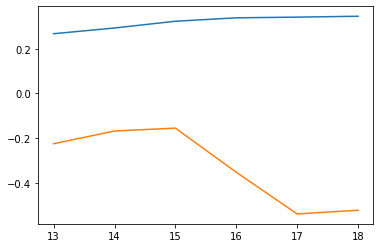

In [26]:
import matplotlib.pyplot as plt

plt.plot(pointNum_list_2, sc_list_2)
plt.plot(pointNum_list_2, cp_list_2)
plt.show()

In [29]:
cp_list_2

[-0.22534356353718243,
 -0.16832081330623835,
 -0.1554531461956363,
 -0.353146016250106,
 -0.5396297312514076,
 -0.5233208970603538]

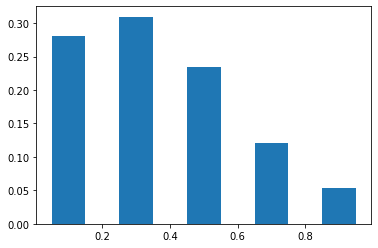

In [17]:
distance_x_ls = [0.1,0.3,0.5,0.7,0.9]
percentage_ls = [0,0,0,0,0]
for i in range(size):
    for j in range(i+1, size):
        temp = matrix[i,j]
        if temp <= 0.2:
            percentage_ls[0] = percentage_ls[0] + 1
        elif temp <= 0.4:
            percentage_ls[1] = percentage_ls[1] + 1
        elif temp <= 0.6:
            percentage_ls[2] = percentage_ls[2] + 1
        elif temp <= 0.8:
            percentage_ls[3] = percentage_ls[3] + 1
        else:
            percentage_ls[4] = percentage_ls[4] + 1
total = sum(percentage_ls)
for i in range(5):
    percentage_ls[i] = percentage_ls[i] / total
plt.bar(distance_x_ls, percentage_ls, 0.1)
plt.show()